# Programming Assignment 5: Yelp, Neural Nets, and Putting it All Together

In this assignment, we'll cap off the first part of the class, which was
focused on text processing, NLP tasks like information retrieval and sentiment
analysis, and tools like word vectors and Naive Bayes that we can use to solve
them.

In Week 2/PA2, we learned about
Naive Bayes and logistic regression, and how they can be used
to solve text classification problems. In Week 5/PA4, we learned about
vector semantics, and how we can use word embeddings as a tool to represent
language and answer semantic questions.

In this assignment, we’ll integrate and expand these ideas to build a new and
powerful tool for your NLP toolkit: a simple neural network!

Neural networks (and in particular, neural networks using semantic word
embeddings) are extremely useful and powerful tools that are behind some
really impressive advances in NLP over the last few years. You'll see plenty of
them in future NLP classes (if you choose to take them), but hopefully this
assignment will give you a first taste of how they work and what you can do
with them!

### Environment Check

Before we do anything else, let's quickly check that you're running the correct
version of Python and are in the right environment!

In [1]:
import os
from typing import Dict, List, Tuple

import gensim.models

assert os.environ['CONDA_DEFAULT_ENV'] == "cs124"

import sys
assert sys.version_info.major == 3 and sys.version_info.minor == 8

If the above cell complains, it means that you're using the wrong environment
or Python version!

If so, please exit this notebook, kill the notebook server with CTRL-C, and
try running

$ conda activate cs124

then restarting your notebook server with

$ jupyter notebook

If that doesn't work, you should go back and follow the installation
instructions in PA0.

## Part 1: Why not Logistic Regression?

Before we build a simple neural network, let's take a brief look back at
logistic regression (from PA2).

Recall that the output of a logistic regression classifier is given by:

$y = \sigma(XW + b)$

Where $W$ was a vector of shape (num_features,), $X$ was a matrix of shape
(num_examples, num_features), $b$ was a scalar added to every element of the
vector $XW$, and y was a vector of shape (num_examples,), and $\sigma()$ is the
sigmoid function.

We showed in PA2 that this approach can work really well for text
classification. However, it has a significant weakness that we need to be
aware of.

To see that, let's bring out our logistic regression classifier again and apply
it to a toy dataset that we've created.

In [2]:
# Import all of the packages we'll need for the rest of the assignment
import numpy as np

np.random.seed(1)

from util import (generate_2d_xor_dataset, plot_2d_dataset_points,
plot_points_with_classifier_predictions, check_forward_pass,
check_backward_pass, load_embeddings, load_dataset, check_examples_to_array,
check_forward_pass_yelp, check_backward_pass_yelp, evaluate)

In [4]:
%matplotlib inline

In [5]:
# Construct an example dataset for us to classify
X, y = generate_2d_xor_dataset()

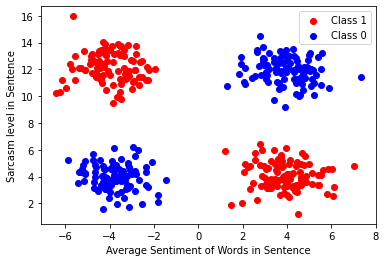

In [6]:
# Plot our example dataset
plot_2d_dataset_points(X, y)

This is what our data looks like! It's a bit of an unusual-looking
distribution. However, datasets with these sorts of properties actually appear
quite often in real life. To give an example of such a real-life situation,
consider the case of doing sentiment analysis, but in the presence of
sarcasm.

We can plot a single point for each sentence, where the $x$ value represents
the average sentiment score of the words in the sentence, and the $y$ value
represents the amount of sarcasm detected in the sentence (imagine we have
some way to measure this).

The data is labeled in two classes: class 0 (blue) means a sentence's true
sentiment is negative, while class 1 (red) means a sentence's true sentiment
is positive.

With that in mind, we can imagine why we might see a pattern like this. Sarcasm
tends to invert the meaning of a sentence. For example, the sentence
"Woooooow, what a FANTASTIC day, I hope it never ends.", by itself appears to
express positive sentiment. If we took the average sentiment score of the words
in the sentence, it would probably be positive, because of the highly
positive word "fantastic". But if we also knew that the speaker was expressing
a lot of sarcasm, then that would imply that the sentence's true sentiment
is the opposite: Negative.

This is why a high average sentiment score and low sarcasm score corresponds
to a positive true sentiment label, but a high average sentiment score and a
high sarcasm score corresponds to a negative true sentiment label!

NOTE: In case you're curious, this dataset was actually generated from 4 normal
distributions with different means and unit variances.

Now, consider how we might attempt to do binary classification on this
dataset. Or to think about it geometrically, how we could draw a line to
separate the blue points from the red points. Visually, it doesn't seem
difficult to imagine such a line (in fact, there's an
infinite number of lines that we could draw to correctly classify all the
points).

However, this dataset is actually an example of a problem that logistic
regression (and other methods like it) can't solve! (See Ch 7.2 of Jurafsky
and Martin for more info on this problem, often called the XOR problem)

Don't believe us? Let's see what happens when we try to apply logistic
regression to this data.

There's no need to implement it again, because we already got plenty of
practice with that in PA2. This time, we'll use Scikit-learn's pre-written
version:

In [7]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression classifier on our data
logistic_regression_classifier = LogisticRegression().fit(X, np.squeeze(y))

And now, let's see what our trained classifier predicts:

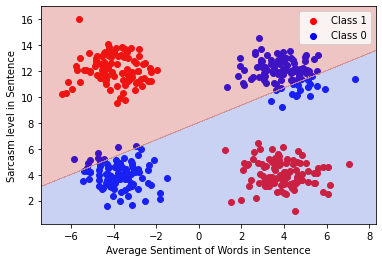

In [8]:
plot_points_with_classifier_predictions(X, y, logistic_regression_classifier)

In this plot, we are showing the points with their true labels as colored dots
(just like the previous plot), but we've overlaid the predictions of the
logistic regression classifier as the colored regions. The blue shaded region
is the area where the classifier is predicting that points are class 0 and a
negative true sentiment. And the red area is where it predicts that points
are class 1 and of positive true sentiment.

So, what just happened?? This prediction is way off! Is Scikit-Learn's
logistic regression classifier broken? It seemed to work so well in PA2...

The answer is actually no: it's working correctly! The reason why it fails
to classify the points correctly here has to do with a fundamental limitation
of logistic regression. It's a __linear__ classifier, so it can only make
predictions by drawing a linear boundary. Remember that our
logistic regression equation is $y = \sigma(XW + b)$. In this case, the
decision boundary is given by $XW + b = 0$.

Can you see why this is true, and why logistic regression is a __linear model__,
even though sigmoid is a non-linear function? Trying picking a particular choice
of $W$ and $b$ and drawing the line given by $XW + b = 0$. Then try plugging
in some different values of $X$. You should find that all points $X$ on one
side of that line will be predicted as class 0, and all points on the other as
class 1.

One interesting thing is that linear models work surprisingly well in practice,
as we saw in PA2! It turns out that drawing a straight line is often enough to
get you a pretty good answer to many problems, especially if you're working
in a high-dimensional space (i.e. you have a lot of input features).

However, as we can see here there are some problems that linear models just
can't deal with.

### One Solution: A Simple Neural Network

One way to think about neural networks is as an extension and improvement on
logistic regression that addresses the above limitation. They do this by
essentially just stacking a bunch of logistic regression classifiers together!

What do we mean by this?

Neural networks are made up of a series of layers. Each of those layers looks
almost exactly like a logistic regression classifier. They can be written as:

$a_l = f(a_{l-1}W_l + b_l)$

Where $a_l$ represents the output of layer $l$ and $f()$ is a non-linear
function called the __activation function__. In the case of logistic regression,
you can think of sigmoid() as the activation function.

To calculate the output of each layer, we take an input ($a_{l-1}$, possibly
the output from the previous layer), multiply it by a
matrix of weights ($W_l$) and add a bias ($b_l$), then apply a non-linear
activation function ($f()$) to it. The weights and bias can be learned, just
like in logistic regression.

If we take a single layer, set $f() = \text{sigmoid}() = \sigma()$, make our
layer input ($a_0$) our input data $X$, and choose the dimensions of $W_1$ and
$b_1$ so that our layer output ($a_1$) is of shape
(num_examples,), that's just logistic regression!

Two important things to note:

1. In logistic regression (one "layer"), our input is always the input data,
and our output is always a prediction score. So the shapes of the inputs and
outputs (and therefore the shapes of $W$ and $b$) were pre-determined. However,
if we're stacking a bunch of these layers together we have some flexibility to
choose the inputs and output shapes, so long as the first layer's
input shape matches the input data, the last layer's output shape is the shape
of the prediction scores, and all the input and output shapes of the layers
in-between match up. This is one way that we can tune and modify our models.

2. The key reason why "stacking" like this is helpful has to do with the fact
that $f()$ is always a non-linear function. We'll see why this is
in a bit!

### The Math

The next thing you'll need to do is implement a multi-layer neural network!
Doing that will require writing some equations. First, consider the equations
to calculate the output of each layer in the network
(i.e. $a_1, a_2, a_3, ...$) from the first layer all the way to the predicted
scores. These are called the __forward pass__:

Define $a_l$ as the output after the non-linearity in layer $l$ and $z_l$ as
the output before the non-linearity in layer $l$. The neural network forward
pass equations are then as follows:

$z_1 = X W_1 + b_1$

$a_1 = \sigma(z_1)$

$z_2 = a_1 W_2 + b_2$

$a_2 = \sigma(z_2)$

$z_3 = a_2 W_3 + b_3$

$a_3 = \sigma(z_3)$

Recall from the modules/reading that we can train a neural network in the same
way as logistic regression, by defining a cost/loss function that expresses
how far off the predictions are from the correct answers, and then using
gradient descent to update the weights and biases to minimize this error.

For this problem, we use the binary cross entropy
cost function (the same as for logistic regression!), defined as:

$J = - (y log(a_3) + (1 - y) log(1 - a_3))$

To do our gradient descent, we need to somehow compute the gradients of the loss
 with respect to for all the weights and biases. We showed what these gradients
 look like for logistic regression in the modules and Ch. 5 of the textbook, but
 now we have multiple "layers" of logistic regressions, and we need to calculate
 the gradients for the weights and biases in every single layer.

We showed in the modules how you can do this with a computational graph and
using the chain rule. This is called the __backward pass__ or backpropagation
(backprop).

In the module/slides (see slide 79), we showed that $\frac{dJ}{dz_3} = a_3 - y$.
Using this fact, the chain rule, and the equations above for the forward pass,
we can calculate the gradients of all of our parameters:

$\frac{dJ}{dz_3} = a_3 - y$

$\frac{dJ}{dW_3} = \frac{1}{m} (a_{2}^T \frac{dJ}{dz_3})$

$\frac{dJ}{db_3} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_3})_i$

$\frac{dJ}{da_2} = \frac{dJ}{dz_3} W_3^T$

$\frac{dJ}{dz_2} = \frac{dJ}{da_2} \circ a_2 \circ (\mathbb{1}-a_2)$

$\frac{dJ}{dW_2} = \frac{1}{m} (a_{1}^T \frac{dJ}{dz_2})$

$\frac{dJ}{db_2} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_2})_i$

$\frac{dJ}{da_1} = \frac{dJ}{dz_2} W_2^T$

$\frac{dJ}{dz_1} = \frac{dJ}{da_1} \circ a_1 \circ (\mathbb{1}-a_1)$

$\frac{dJ}{dW_1} = \frac{1}{m} (X^T \frac{dJ}{dz_1})$

$\frac{dJ}{db_1} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_1})_i$

__NOTE:__ Note that to compute the gradients we use to update our weights and
biases, we take the mean of the gradients over all $m$ examples.

### TODO: Implementing the Network

Now we have all the information we need to implement a simple neural network
that consists of three logistic regression layers "stacked together"!

If the code below seems intimidating at first, don't worry! On closer
inspection, it should look very familiar: it's only a slight modification of
the code you wrote in PA 2 for your logistic regression classifier.

The most complicated part will probably be computing the gradients in
backward_pass(), but for that, you can refer closely to the equations we
wrote above.

In [9]:
class StackedLogisticRegressionNetwork:
    def __init__(self, input_size: int, layer_1_size: int, layer_2_size: int,
                 seed: int = 1):
        """
        TODO: Initialize the weights and biases of the 3 layers. You should
        initialize the weights randomly with initialize_weights() for each
        layer, and initialize the biases to zero for each layer.

        Args:
            input_size (int): The size of the input (number of input features/
                             number of dimensions of the input points).
            layer_1_size (int): The number of hidden units in the first hidden
                                layer.
            layer_2_size (int): The number of hidden units in the second hidden
                                layer.
            seed (int): Random seed to use when initializing weights.

        HINT: You should use the initialize_weights() method that we give you to
        initialize the weights for each layer (although you'll need to figure
        out what the correct shapes are).

        HINT: The shape of the bias for each layer should be (1, layer_size).
        You should use np.zeros() to initialize your biases to zero.

        WARNING: Do NOT change the order in which the weights are initialized
        below, as this may cause your random initialization to be different from
        ours when running tests.
        """
        np.random.seed(seed)

        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        self.W_1 = self.initialize_weights(input_size, layer_1_size) 
        self.b_1 = np.zeros(layer_1_size) 
        self.W_2 = self.initialize_weights(layer_1_size, layer_2_size)
        self.b_2 = np.zeros(layer_2_size)
        self.W_3 = self.initialize_weights(layer_2_size, 1)
        self.b_3 = np.zeros(1) 
        """
        ######################## YOUR CODE ENDS HERE ###########################
        """

        self.variables = {
          "W_1": self.W_1,
          "b_1": self.b_1,
          "W_2": self.W_2,
          "b_2": self.b_2,
          "W_3": self.W_3,
          "b_3": self.b_3
        }

    @staticmethod
    def initialize_weights(num_inputs: int, num_outputs: int) -> np.ndarray:
        """
        Initialize the weights in a specific way to help gradient descent
        converge better (Glorot initialization).

        Args:
            num_inputs (int): The number of inputs to the layer.
            num_outputs (int): The number of outputs (units) in the layer.

        Returns:
            np.ndarray: A fully initialized NumPy array of weights, of shape
            (num_inputs, num_outputs)
        """
        bound = np.sqrt(6 /(num_inputs + num_outputs))
        return np.random.uniform(-bound, bound, (num_inputs, num_outputs))

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """
        The sigmoid function, exactly the same as in PA2. NOTE: Applied
        element-wise to each element in the array x.

        Args:
            x (np.ndarray): A NumPy array.

        Returns:
            np.ndarray: An array of the sigmoid function applied to each element
                        of x. Shape is the same as x.
        """
        return 1 / (1 + np.exp(-x))

    def forward_pass(self, X: np.ndarray) ->\
            Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        TODO: Calculate the outputs of each of the three layers in the model
        using the inputs, weights, and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of three NumPy
                arrays, corresponding to the output (after activation) of the
                first layer ($a_1$), second layer ($a_2$), and third/output
                layer ($a_3$).


        HINT: Your goal here is to essentially translate the forward pass
        equations above from math into Python/NumPy.

        HINT: Your output a_1 should look exactly like the output of a logistic
        regression classifier on X. Your output a_2 should look exactly like
        the output of another logistic regression classifier on the input a_1.
        And same again for a_3. Note that you should use the appropriate
        weights and biases for each part though.

        HINT: Don't forget to apply the self.sigmoid() between each layer!

        HINT: Your output a_3 should be of shape (num_examples, 1), because it
        represents the final predictions of our neural network for each example.
        For each example, it contains a single number between 0 and 1 for each
        example. If it is close to 1, the network thinks the example is probably
        class 1, and if it is close to 0, the network thinks the example is
        probably class 0.

        NOTE: We will need to use these 3 values later when computing the
        gradients in backward_pass().
        """

        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        a_1 = self.sigmoid(np.dot(X, self.variables["W_1"]) + self.variables["b_1"])
        a_2 = self.sigmoid(np.dot(a_1, self.variables["W_2"]) + self.variables["b_2"])
        a_3 = self.sigmoid(np.dot(a_2, self.variables["W_3"]) + self.variables["b_3"])
        """
        ######################## YOUR CODE ENDS HERE ###########################
        """
        return a_1, a_2, a_3

    def backward_pass(self,
                      X : np.ndarray,
                      y : np.ndarray,
                      a_1: np.ndarray,
                      a_2: np.ndarray,
                      a_3: np.ndarray
                      ) -> Dict[str, np.ndarray]:
        """
        TODO: Use the examples, labels, and model outputs to compute the
        gradient for each of the weights and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1).
            a_1 (np.ndarray): The output of the first logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_2 (np.ndarray): The output of the second logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_3 (np.ndarray): The output of the third logistic regression
                              layer (after activation). Computed in
                              forward_pass().

        Returns:
            Dict[str, np.ndarray]: A dictionary of the gradients computed for
                                    each weight and bias parameter. The keys
                                    are strings, the values are NumPy arrays
                                    (see the names of the keys below).

        HINT: Your goal here is essentially to translate the backprop equations
        (the equations for the gradients) below into NumPy calculations.

        HINT: One great thing to use as a sanity-check is that your gradient for
        each parameter should be the same shape as the parameter itself! For
        example, your gradient dW_3 should be the exact same shape as self.W_3.

        HINT: The first dimension of X and y is the number of examples/data
        points. Note that the shape of the gradients should not depend on the
        number of examples, so this dimension should be averaged out or
        otherwise "cancelled out" when computing each gradient.

        HINT: When multiplying matrices, remember that you can either use
        np.matmul(), or the "@" operator, both do the same thing.

        HINT: You will probably want to use np.mean() to do some averaging.
        Remember that you can pass a "axis" argument to only average along a
        single dimension.

        For example, if we wanted to average an array A of shape (10, 20) along
        the second dimension, we could call np.mean(A, axis=1). This will return
        an array of shape (10,). If we want to keep the second dimension of
        length 1, we can use keepdims=True. So np.mean(A, axis=1, keepdims=True)
        would return an array of shape (10, 1).

        HINT: You'll probably find it useful to compute:
          - dz_3
          - da_2
          - dz_2
          - da_1
          - dz_1
          as you do your calculations.
        """

        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        
        m = len(X) #num_examples
        
        dz_3 = a_3 - y 
        dW_3 = (1/m)*(np.matmul(np.transpose(a_2), dz_3))
        db_3 = np.mean(dz_3, axis = 0)
        da_2 = np.matmul(dz_3, np.transpose(self.variables["W_3"]))
        dz_2 = np.multiply(da_2, np.multiply(a_2, np.ones_like(a_2) - a_2))
        dW_2 = (1/m)*(np.matmul(np.transpose(a_1), dz_2))
        db_2 = np.mean(dz_2, axis = 0)
        da_1 = np.matmul(dz_2, np.transpose(self.variables["W_2"]))
        dz_1 = np.multiply(da_1, np.multiply(a_1, np.ones_like(a_1) - a_1))
        dW_1 = (1/m)*np.matmul(np.transpose(X), dz_1)
        db_1 = np.mean(dz_1, axis = 0)
        
        """
        ######################## YOUR CODE ENDS HERE ###########################
        """

        # Return the gradients
        gradients = {
          "W_3": dW_3,
          "b_3": db_3,
          "W_2": dW_2,
          "b_2": db_2,
          "W_1": dW_1,
          "b_1": db_1
        }

        return gradients

    @staticmethod
    def loss(y_hat : np.ndarray,
             y : np.ndarray,
             epsilon: float=1e-16) -> float:
        """
        Computes the average binary cross-entropy loss over all examples. This
        is the same loss function we implemented for logistic regression in PA2.

        Args:
            y_hat (np.ndarray): The NumPy array of our prediction scores. This
                                is the same as the output a_3 from
                                forward_pass(). It is of shape
                                (num_examples, 1), and
                                each element is between 0.0 and 1.0.
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            epsilon (float): A tiny value used to clip y_hat so that it is never
                             accidentally rounded to 1.0 or 0.0, causing
                             the log to become undefined.

        Returns:
            float: The average binary cross-entropy loss over the num_examples
                    examples.
        """
        # We clip the predictions so they can never become exactly 0 or 1.
        # This would cause the log of the predictions to be undefined.
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        return -1 * np.mean(y * np.log(y_hat) + (1.0 - y) * np.log(1.0 - y_hat))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        TODO: Convert the prediction scores (output a_3 in self.forward_pass())
        to binary predictions.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            np.ndarray: A NumPy array of shape (num_examples, 1) containing the
                        predicted class for each example. Each element should
                        be either 0 or 1.

        HINT: The predictions scores will be numbers between 0 and 1, for
        example a prediction score of 0.8 means that the neural network thinks
        there is an 80% chance it is in class 1 and a 20% chance that it is in
        class 0. Your job is to take this score and convert it to a
        black-and-white guess (exactly 0 or 1). As an example, if the prediction
        score is 0.51, the prediction should be 1. If it is 0.49, the prediction
        should be 0.
        """
        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        a_3 = self.forward_pass(X)[2] #a_3 
        
        predictions = np.array([np.array([1]) if x >= 0.5 else np.array([0]) for x in a_3])
        
        """
        ######################## YOUR CODE ENDS HERE ###########################
        """
        return predictions

    def train(self,
              X_train: np.ndarray,
              y_train: np.ndarray,
              learning_rate: float = 0.01,
              num_epochs: int = 1000,
              print_every: int = 5,
              verbose: bool=True):
        """
        Trains the neural network using gradient descent.

        Args:
            X_train (np.ndarray): The NumPy array of training examples, of shape
                            (num_examples, input_size).
            y_train (np.ndarray): The NumPy array of true labels for each
                            example in X_train. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            learning_rate (np.ndarray): Step size parameter for gradient
                                descent.
            num_epochs (int): The number of epochs (full passes through the
                                provided training data) to train the model for.
            print_every (int): Number of epochs to wait between printouts of the
                                training loss and accuracy during training.
            verbose (bool): Whether to print any training output.

        This code should look very familiar to you from PA2. It's pretty much
        exactly the same code we used to train our logistic regression model,
        except this time you implemented the part that computes the gradients!
        """
        for epoch in range(1, num_epochs + 1):
            a_1, a_2, a_3 = self.forward_pass(X_train)
            gradients = self.backward_pass(X_train, y_train, a_1, a_2, a_3)
            # Update the weights with gradient descent
            for name, grad in gradients.items():
                self.variables[name] -= learning_rate * grad
            # Occasionally print out the training loss and accuracy
            if verbose and epoch % print_every == 0:
                loss = self.loss(a_3, y_train)
                accuracy = np.mean(self.predict(X_train) == y_train)
                print("Epoch: {} | Training Loss: {} | Training Accuracy: {}".format(
                    epoch, loss, accuracy))
        print("Finished training!")

In [10]:
def initialize_weights_test(num_inputs: int, num_outputs: int) -> np.ndarray:
        """
        Initialize the weights in a specific way to help gradient descent
        converge better (Glorot initialization).

        Args:
            num_inputs (int): The number of inputs to the layer.
            num_outputs (int): The number of outputs (units) in the layer.

        Returns:
            np.ndarray: A fully initialized NumPy array of weights, of shape
            (num_inputs, num_outputs)
        """
        bound = np.sqrt(6 /(num_inputs + num_outputs))
        return np.random.uniform(-bound, bound, (num_inputs, num_outputs))

In [11]:
test_W1 = initialize_weights_test(3, 2) # num_inputs : 3, num_outputs: 2
test_X1 = np.ndarray((4 , 3)) # num_examples = 4, input_size = 3
z_1 = np.dot(test_X1, test_W1)

In [16]:
test_X1


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.]])

In [22]:
(1/2)*test_X1

array([[0.5, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0.5]])

In [20]:
np.mean(test_X1, axis = 1, keepdims = True)


array([[0.33333333],
       [0.33333333],
       [0.        ],
       [0.33333333]])

In [12]:
test_W1

array([[ 0.55146399,  0.57539809],
       [-0.0668681 , -0.63368323],
       [-1.00457777, -0.39035354]])

In [14]:
len(test_W1)

3

In [15]:
np.transpose(test_W1) 

array([[ 0.55146399, -0.0668681 , -1.00457777],
       [ 0.57539809, -0.63368323, -0.39035354]])

In [26]:
z_1

array([[ 0.35756552, -0.42968756],
       [ 0.32262688, -0.69944183],
       [ 0.67931257, -0.39156855],
       [-0.24842896,  0.19012614]])

In [37]:
b_1 = np.zeros(4)


In [38]:
b_1_tr = np.transpose(b_1)

In [39]:
b_1_tr 

array([0., 0., 0., 0.])

In [18]:
np.dot(np.transpose(test_W1), test_X1)

array([[ 3.15823981],
       [ 1.24041771],
       [ 1.34063686],
       [-0.20256868]])

In [20]:
test_bias = np.zeros(4)

In [21]:
test_bias


array([0., 0., 0., 0.])

In [67]:
def multiple_return_func(): 
    a = 2
    b = 3
    c = 1
    return a, b, c 

In [69]:
multiple_return_func()[2]

1

In [80]:
predictions_test = np.array([0.51, 0.4, 0.77])

predictions_outcome = np.array([np.array([1]) if x > 0.5 else np.array([0]) for x in predictions_test])

In [81]:
predictions_outcome


array([[1],
       [0],
       [1]])

Once you've implemented the code for forward_pass() and backward_pass() above,
you can check your work by running the tests below!

__WARNING:__ The tests below are just sanity checks, they do __NOT__ provide
a guarantee that your implementation is 100% correct. We encourage you to
do additional checking and testing to convince yourself that everything
is working correctly. You can see how the checks are implemented in util.py.

In [12]:
check_forward_pass(StackedLogisticRegressionNetwork, X)

Forward pass output a_1 is correct.
Forward pass output a_2 is correct.
Forward pass output a_3 is correct.


In [13]:
check_backward_pass(StackedLogisticRegressionNetwork, X, y)

Backward pass gradient W_3 is correct.
Backward pass gradient b_3 is correct.
Backward pass gradient W_2 is correct.
Backward pass gradient b_2 is correct.
Backward pass gradient W_1 is correct.
Backward pass gradient b_1 is correct.


If you passed the two tests above, congratulations! In all likelihood, you have
just written a working neural network! Now for the final test:
__training and testing it__.

Just like our logistic regression classifier in PA2, we can train our model
with gradient descent. You can check out the train() function to see how it
works (basically exactly the same as in PA2).

The only difference is that because we've stacked 3 logistic regressions
together, we have 3 times the numbers of weights and biases, and computing the
gradients for them is a little trickier due to how they stack on top of one
another. However, you did all of that in backward_pass()!

Let's give it a whirl!

In [14]:
# We choose the size of the 2nd and 3rd layers to be 10. More on this below.
neural_network_classifier = StackedLogisticRegressionNetwork(2, 10, 10)
neural_network_classifier.train(X, y,
                                learning_rate=0.1,
                                num_epochs=10000,
                                print_every=1000)

Epoch: 1000 | Training Loss: 0.1180876689641853 | Training Accuracy: 0.9775
Epoch: 2000 | Training Loss: 0.04890215604524648 | Training Accuracy: 0.985
Epoch: 3000 | Training Loss: 0.028576947917098226 | Training Accuracy: 0.9975
Epoch: 4000 | Training Loss: 0.01886278473848203 | Training Accuracy: 1.0
Epoch: 5000 | Training Loss: 0.013537239385065099 | Training Accuracy: 1.0
Epoch: 6000 | Training Loss: 0.010305221676011125 | Training Accuracy: 1.0
Epoch: 7000 | Training Loss: 0.008182445195134629 | Training Accuracy: 1.0
Epoch: 8000 | Training Loss: 0.006702861812892453 | Training Accuracy: 1.0
Epoch: 9000 | Training Loss: 0.005624187477065306 | Training Accuracy: 1.0
Epoch: 10000 | Training Loss: 0.004809804044181595 | Training Accuracy: 1.0
Finished training!


Now let's plot the resulting predictions, just like we did with the logistic
regression classifier:

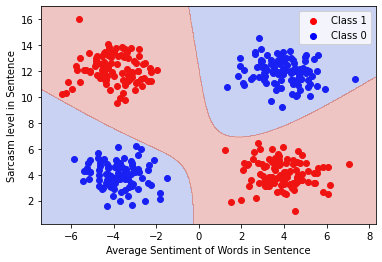

In [15]:
plot_points_with_classifier_predictions(X, y, neural_network_classifier)

Wow! This worked a lot better than logistic regression!

In particular, note that it is not subject to the same limitation as logistic
regression: the boundary is no longer linear!

It's the fact that the boundary is not linear that allows us to correctly
classify this dataset. No single straight line could correctly put all the red
points on one side and all blue ones on the other side, but a curved line can!

You might be wondering: Why is this model (which is just three stacked logistic
 regression layers) non-linear, when a single logistic regression layer is
linear?

The answer has to do with what happens when we have multiple layers together,
each of which includes a non-linear activation functions.

### Non-linear Magic

Let's consider a slightly different model:

Consider a 2-layer neural network where __we only apply the sigmoid after the
final layer__, but not the first layer.

The equation of the first layer is:

$z_1 = X W_1 + b_1$

The equation of the second layer is:

$z_2 = \sigma(z_1 W_2 + b_2) = \sigma((X W_1 + b_1) W_2 + b_2)
= \sigma(X W_1 W_2 + b_1 W_2 + b_2)$

Note that this is still a linear model! The decision boundary will still be a
straight line (do you see why?).

What happens if we stack two layers, __but apply a non-linear sigmoid function
between every layer__?

The equation of the first layer is:

$z_1 = \sigma(X W_1 + b_1)$

The equation of the second layer is:

$z_2 = \sigma(z_1 W_2 + b_2) = \sigma(\sigma(X W_1 + b_1) W_2 + b_2)$

This is a non-linear model! The decision boundary can't be expressed as a linear
function. Do you see why (hint: compare what is inside the outer sigmoid between
the first case and the second case)?

It's this ability to create a non-linear decision boundary by stacking
multiple layers (with non-linear functions in between) that makes neural
networks more powerful than logistic regression, and potentially more useful
for solving challenging problems that can't be separated linearly.

### Some Final Thoughts on Part 1

__Layer Sizes__

You can see that when training our model, we chose our input size to be 2, and
our hidden layer sizes to both be 10.

The input size (size of the first logistic regression layer)
we didn't have any choice about, because we have to match whatever our input
data X looks like. In this case, we had 2-dimensional inputs, so our input size
is 2.

But for the second and third logistic regression layers, we're free
to choose any size we'd like! Choosing larger sizes means more parameters, which
means our boundary can potentially become more complex and fancy, which we might
need to solve harder problems. But it also means more numbers to crunch when
calculating the gradients, which can make training take longer. In practice,
there's no strict rule for choosing the perfect layer sizes.
Usually you just have to experiment with some different choices
and see what works well!

__[Try this:]__ We'd encourage you to go back and try changing the layer sizes
and see what happens to your model's training and predictions! What happens
when you choose super tiny layer sizes (1, 2)? What about super large ones
(100, 1000, 10000)?

Finally, note that no matter what sizes we choose for the second and third
layers, the final output has to be a single number (prediction score) for each
example in X, which is why the last layer's size is determined for us.

__Non-linear functions__

In our example model we stacked 3 logistic regressions together, and logistic
regression uses the sigmoid function on its output. That's why we ended up with
3 sigmoid functions sandwiched between the layers of our network.

The final sigmoid (after the last layer) is mandatory, for the same reason
that we needed it in our original logistic regression classifier. We want our
outputs to all be probabilities in the range (0, 1), and the sigmoid function
lets us squeeze them down into this range.

However, for the "inner" sigmoids, in-between the hidden layers, we don't
necessarily have to use sigmoids at all! The reasoning above about having a
non-linear boundary would apply equally well if we used a different non-linear
function instead of sigmoid (you can look back and verify that every step above
still makes sense if we replace $\sigma$ with any other non-linear
function).

In practice, most "real" neural networks don't use sigmoid (for reasons we won't
go into, but that you'll learn more about in future deep learning classes). Instead, they use
other simple non-linear functions, most commonly ReLU, which we mentioned in
the modules and which we'll use in a minute.

## Part 2: Yelp Review Classification

Now that we've seen what neural networks can do, it's time to apply them to
some real language data! More specifically, we'll return to sentiment analysis,
which you should be very familiar with from PA2. However, now we'll see how a
neural network fares on this task.

More specifically, our goal will be to take in data in the form of Yelp reviews
of various businesses and predict, just from the text of the review itself,
whether the reviewer's opinion was positive or negative!

To do that, we need to take one last detour to the world of vector semantics:

### Embeddings

You'll recall from PA4 that semantic word vectors, or word embeddings, are a
very useful and powerful way to represent words.
We showed how you can look at the geometric properties of these vectors and use
them to show relationships between words, like analogies or word similarity.

That's only a small part of what makes embeddings so useful and interesting!
Embeddings are a key building block for solving all sorts of other language and
NLP-related problems. Once we've transformed words and text into numerical
values, that lets us apply all sorts of tools from our machine learning toolbox
to the problem we're interested in.

Neural networks are one such category of machine learning tools (and an
extremely popular one). Recall how our simple neural network above was able to
take 2D points (in other words, 2-dimensional vectors of numbers) as inputs, and
output predictions. If we could just convert our text or words into a similar
format (vectors of numbers), then we could feed them into a neural
network in the same way.

Word embeddings are just what we need to do this.

For this assignment, we've provided you with a set of pre-computed word
embeddings. In particular, they are generated using the GloVe method that was
mentioned in the slides and textbook readings. To avoid having to work with a
huge amount of data, we've pre-selected only a
subset of the full GloVe vocabulary and given it to you in a file (you can
actually read the text file yourself to see what it looks like, if you're
curious).

We can load the embeddings into a Python object using a function we wrote
(see util.py) and with the help of Gensim:

In [16]:
# Load in our embeddings from a text file
embeddings = load_embeddings("data/glove.dataset_small.50d.txt")

Each of the embeddings is a NumPy vector, and we can access them by simply
looking up the word we are interested in (as a string) in the embeddings object.

Like this:

In [17]:
# Print out some of our embeddings
words = ['the', 'good', 'red']

for word in words:
    print("{} : {}".format(word, embeddings[word]))

the : [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
good : [-3.5586e-01  5.2130e-01 -6.1070e-01 -3.0131e-01  9.4862e-01 -3.1539e-01
 -5.9831e-01  1.2188e-01 -3.1943e-02  5.5695e-01 -1.0621e-01  6.3399e-01
 -4.7340e-01 -7.5895e-02  3.8247e-01  8.1569e-02  8.2214e-01  2.2220e-01
 -8.3764e-03 -7.6620e-01 -5.6253e-01  6.1759e-01  2.0292e-01 -4.8598e-02
  8.7815e-01 -1.6549e+00 -7.7418e-01  1.5435e-01  9.4823e-01 -3.9520e-01
  3.7302e+00

We also added a special token, "<unk\>", which represents any word that isn't in
the embedding vocabulary (i.e. any word that we don't have an embedding for).
The embedding for that token is just the average of the embeddings of all the
other words.

This will be important later, because there are plenty of words that we don't
have embeddings for (you can try looking up a nonsense word in embeddings and
see what happens).

In [17]:
print("<unk> embedding : {}".format(embeddings["<unk>"]))

<unk> embedding : [ 0.07716928 -0.1802469  -0.11035916 -0.16697723 -0.06232838  0.0463623
  0.11975443 -0.0435423  -0.02259983  0.18313928 -0.02515728  0.0803395
  0.10476907  0.07825337 -0.0111994   0.01126366 -0.0685114   0.11889402
  0.12636156 -0.09540337 -0.0902544   0.02815295  0.09944868  0.02829519
  0.12216888 -0.06393122 -0.13079482  0.20009348  0.17269585 -0.1395835
  0.31548336  0.10522317  0.04977985  0.12167727 -0.0197358   0.10907073
 -0.02500999  0.0197609  -0.01843753 -0.00395017  0.00934928 -0.08024932
 -0.05142293  0.23837452  0.04379626 -0.10308132  0.14058053 -0.00361709
  0.00270127 -0.05709274]


In [89]:
embeddings["blibloup"]

KeyError: "word 'blibloup' not in vocabulary"

### Preparing the Data

Now we have a way to translate our text data into a form that our neural
network can use! Let's load up some data and do just that.

The code below loads our dataset in from a file (see util.py for details):

In [18]:
train_examples, train_labels = load_dataset("data/train.csv")
dev_examples, dev_labels = load_dataset("data/dev.csv")

Each element in train_examples is a Yelp review that we've preprocessed into a
list of words. We've already taken out punctuation, segmented the words, and
converted them all to lower case for you, to make them easier to work with.

Each element in train_labels is the review's corresponding positive/negative
label. As you probably know if you've ever used Yelp, ratings are normally from
1-5 stars. However, in this case we've transformed the original star
ratings into two labels (0 or 1) by collapsing 1 and 2-star reviews into the
negative class (label 0) and 4 and 5-star reviews into the positive class
(label 1). We ignore 3-star reviews, because they may be ambiguous and difficult
for our classifier to handle.

dev_examples and dev_labels are a separate development set of examples, but
have the exact same format.

We can examine a couple reviews and their ratings:

In [19]:
EXAMPLES_TO_PRINT = 5

for text, label in zip(train_examples[:EXAMPLES_TO_PRINT],
                       train_labels[:EXAMPLES_TO_PRINT]):
    print("Review: {}".format(" ".join(text)))
    print("Sentiment: {}".format(label))
    print("\n")

Review: taste wise this is one of the best if not the best coffee ive ever had its like im back in europe and the taste is so different and to make the experience even better the latte art is beautiful and the atmosphere is very relaxed and good for studying its just too bad the location is so bad for me personally but its sometimes worth the hour of public transportation so that i can get quality work done
Sentiment: 1


Review: these donuts are the best i actual crave these donuts there are light and delicate and fried to perfection have never had such an awesome donut ever there croissants and french breads are delicious as well they also serve up sandwiches and smoothies you cant go wrong when choosing boss has your one stop shop for great donuts croissants and french bread
Sentiment: 1


Review: at last i finally found an auto repair shop that i can trust took my 2005 toyota highlander in for a problem with the temperature control the estimate was 1200 mike and his crew found that

To turn these words and labels into something we can work with, we'll need to
do a little work.

First, we need to convert each of the words in each review into word embeddings.
But there is a catch: we might not have an embedding for every word in every
review. In the event that we encounter an unknown word (that we don't have an
embedding for), we can use the "<unk\>" embedding as its embedding instead.
You'll implement this as part of examples_to_array().

Next, we need to handle the fact that reviews can be of varying lengths
(different numbers of words), while our simple neural network can only take
input of a single, fixed size. For example, in our simple neural network above,
our inputs were all size 2 (2D points).

We mentioned a similar issue to this in the modules in the context of neural
language models. There are a couple of different ways to handle it, but in this
case we will compress all the words (word embeddings) in each review into a
single, fixed-size vector for the entire review. We can do this by taking the
average of all of the word embeddings in the review, or alternatively taking
the sum or the element-wise maximum. After doing this, each review will be
represented by a single vector of the same size. You'll implement this as part
of aggregate_embeddings() below.

In [20]:
def aggregate_embeddings(list_of_embeddings: List[np.ndarray],
                         mode: str="mean") -> np.ndarray:
    """
    TODO: Take a review in the form of a list of embedding vectors
    and return a vector (of the same shape as a single embedding vector)
    that represents the entire sentence.

    You need to support 3 modes: "mean", "sum", and "max".

    Args:
        list_of_embeddings (List[np.ndarray]): A list of word embeddings, which
                                                collectively represent a single
                                                Yelp review. The list includes
                                                one word embedding for each
                                                word in the review. Each word
                                                embedding is a vector of
                                                shape (50,).
        mode (str): How to aggregate all of the word embeddings in the review
                    together. There are only 3 valid modes: mean, sum, and max.
                    Mean and sum are self-explanatory. Max takes the
                    element-wise max of the embeddings.

    Returns:
        np.ndarray: A single vector representing the entire Yelp review. It
        should be of shape (50,), the same shape as a single word embedding.

    HINT: For max, you can use np.amax().
    """

    """
    ######################## YOUR CODE STARTS HERE #############################
    """
    
    array = np.array(list_of_embeddings)
    
    if mode == "mean":
        aggregated = np.mean(array, axis = 0)
    elif mode == "sum":
        aggregated = np.sum(array, axis = 0)
    elif mode == "max":
        aggregated = np.amax(array, axis = 0)
    else:
        raise ValueError("Invalid mode: {}".format(mode))
    """
    ######################## YOUR CODE END HERE ################################
    """
    return aggregated

def examples_to_array(examples: List[List[str]],
                      embeddings: gensim.models.KeyedVectors,
                      mode: str="mean"):
    """
    TODO: Take a list of Yelp reviews, where each review is a list
    of words, and convert it into an array of shape (num_examples,
    embedding size) where each row is the aggregated embedding representing
    that review.

    Args:
        examples (List[List[str]]): A list of examples, where each example is
                                    a Yelp review. Each example/review is
                                    represented as a list of words, where each
                                    word is a separate string. This is the
                                    first output of the load_dataset() function
                                    above.
        embeddings (gensim.models.KeyedVectors): The embeddings object loaded
                                                earlier with load_embeddings().

        mode (str): The mode argument to pass in to aggregate_embeddings().

    Returns:
        np.ndarray: A single NumPy array containing the vector for each example
                    (review) in the list of examples. Should be of shape
                    (num_examples, 50).

    HINT: You will need to handle words that are not in the vocabulary!
    If a word is not in the vocabulary, then (word in embeddings) will
    be False. In that case, you should use the "<unk>" embedding
    as the embedding for the unknown word.

    HINT: You first need to convert each word in a sentence into an
    embedding, using embeddings. Then once you have a list of embeddings
    (one for each word), use aggregate_embeddings() on each sentence to get
    a single vector of shape (embedding_size,) per sentence. Then you
    need to combine these vectors into an array of shape (num_examples,
    embedding_size).
    """
    """
    ######################## YOUR CODE STARTS HERE #############################
    """
    # Pseudo code 
    # Create the list of list of embeddings : empty list, then append the embedding corresponding to each word in examples, this will 
    # give a list for each review => compile into a list of lists.  
    
    examples_list = []
    
    for example in examples: 
        list_of_embeddings = []
        for word in example: 
            if word in embeddings: 
                list_of_embeddings.append(embeddings[word])
            else: 
                list_of_embeddings.append(embeddings['unk'])
        aggregate = aggregate_embeddings(list_of_embeddings, mode)
        examples_list.append(aggregate)
        
    examples_array = np.array(examples_list)
    
    """
    ######################## YOUR CODE END HERE ################################
    """
    return examples_array

In [21]:
embedding_1 = np.array([1, 2, 3])
embedding_2 = np.array([2, 3, 4])
embedding_3 = np.array([3, 4, 5])

list_of_embeddings_test = [embedding_1, embedding_2, embedding_3]

array_test = np.array(list_of_embeddings_test)

mean = np.mean(array_test, axis = 0)
summ = np.sum(array_test, axis = 0)
maxx = np.amax(array_test, axis = 0)

In [95]:
array_test

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [97]:
mean 

array([2., 3., 4.])

In [99]:
summ

array([ 6,  9, 12])

In [100]:
maxx

array([3, 4, 5])

You can test your implementation with this check (again, this is not a foolproof
guarantee of correctness):

In [103]:
check_examples_to_array(examples_to_array, embeddings)

Output for mode mean is correct.
Output for mode sum is correct.
Output for mode max is correct.


Fantastic! Let's finish up by pre-processing our entire dataset with the code
that you wrote:

__This may take a few seconds.__

In [22]:
# Note that we use expand_dims to change the shape of the labels from
# (num_examples,) to (num_examples, 1) as our model requires.
train_examples_array = examples_to_array(train_examples, embeddings)
train_labels_array = np.expand_dims(np.array(train_labels), axis=1)

dev_examples_array = examples_to_array(dev_examples, embeddings)
dev_labels_array = np.expand_dims(np.array(dev_labels), axis=1)

### TODO: Yelp Review Classification Model

And now all we need to do is tweak our previous model slightly to work on our
new problem. We'll need to do a couple of things:

1. In our previous network, we applied the sigmoid function 3 times, once for
each layer. This time, we'll use a different non-linear function (the __ReLU__
function) for hidden layers, but still use sigmoid on our final output. This
is slightly more realistic (ReLU is the more commonly used activation function
in real-world neural networks, and should help our model learn better on this
more difficult task).

2. We'll use a slightly different training method (mini-batch gradient descent
instead of gradient descent), because our dataset is much larger now and it
will be difficult to do the calculations on the whole dataset at once.

3. We'll use a slightly different way of initializing the weights, so that the
initialization is better suited to our new ReLU activation functions.

We've taken care of 2 and 3 for you, so your only task here will be
implementing #1 and updating the forward and backward passes accordingly:

### Some Helpful Information:

__ReLU__: The ReLU (rectified linear unit) function is a simple non-linear
function that we often use in neural networks. We described it in the
modules/textbook. It is calculated as:

$ReLU(x) = \max(0, x)$

Furthermore, the gradient of the relu function is:

$\frac{d}{dx} ReLU(x) = \begin{cases}
   0 &\text{if } x < 0 \\
   1 &\text{if } x \geq 0
\end{cases}$

Note that when we apply the ReLU function to an array, we apply it to every
element in the array separately. The same goes when calculating the gradient of
ReLU. We compute it separately element-by-element (it has a 0
for each element that is negative, and a 1 for each element that is
non-negative).

### The Math, Version 2

To give you a hand with the implementation, just like we did above in Part 1,
we'll write out the equations for the forward and backward passes. Note that
these are slightly different now, because we've changed the activations for the
hidden layers from sigmoid() to ReLU().

For our modified network, the forward pass equations are:

$z_1 = X W_1 + b_1$

$a_1 = ReLU(z_1)$

$z_2 = a_1 W_2 + b_2$

$a_2 = ReLU(z_2)$

$z_3 = a_2 W_3 + b_3$

$a_3 = \sigma(z_3)$

The loss function is still the same (binary cross-entropy loss):

$J = - ( y log(a_3) + (1 - y) log(1 - a_3) )$

And the gradients computed during the backward pass are:

$\frac{dJ}{dz_3} = a_3 - y$

$\frac{dJ}{dW_3} = \frac{1}{m} (a_{2}^T \frac{dJ}{dz_3})$

$\frac{dJ}{db_3} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_3})_i$

$\frac{dJ}{da_2} = \frac{dJ}{dz_3} W_3^T$

$\frac{dJ}{dz_2} = \frac{dJ}{da_2} \circ 1\{a_2 > 0\}$

$\frac{dJ}{dW_2} = \frac{1}{m} (a_{1}^T \frac{dJ}{dz_2})$

$\frac{dJ}{db_2} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_2})_i$

$\frac{dJ}{da_1} = \frac{dJ}{dz_2} W_2^T$

$\frac{dJ}{dz_1} = \frac{dJ}{da_1} \circ 1\{a_1 > 0\}$

$\frac{dJ}{dW_1} = \frac{1}{m} (X^T \frac{dJ}{dz_1})$

$\frac{dJ}{db_1} = \frac{1}{m} \sum_{i=1}^m (\frac{dJ}{dz_1})_i$

In [48]:
class YelpClassificationNeuralNetwork(StackedLogisticRegressionNetwork):
    def __init__(self, *args, **kwargs):
        super(YelpClassificationNeuralNetwork, self).__init__(*args, **kwargs)

    @staticmethod
    def initialize_weights(num_inputs: int, num_outputs: int) -> np.ndarray:
        """
        We overwrite the previous weight initialization approach with a slightly
        different one that works better with our new ReLU activations (He
        initialization).

        Args:
            num_inputs (int): The number of inputs to the layer.
            num_outputs (int): The number of outputs (units) in the layer.

        Returns:
            np.ndarray: A fully initialized NumPy array of weights, of shape
            (num_inputs, num_outputs)
        """
        stddev = np.sqrt(2 /(num_inputs + num_outputs))
        return np.random.normal(0, stddev, (num_inputs, num_outputs))

    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        """
        TODO: Implement the ReLU function.

        Args:
            x (np.ndarray): A NumPy array of any shape.

        Returns:
            np.ndarray: A new NumPy array where each element is the output
                        of applying ReLU to the corresponding element of x.
                        The shape of the output should be identical to the
                        shape of x.
        """
        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        relu_x = x * (x > 0)
        """
        ######################## YOUR CODE END HERE ############################
        """
        return relu_x
    
    @staticmethod
    def relu_derivate(x: np.ndarray) -> np.ndarray: 
        deriv = 1 * (x > 0)
        return deriv

    def forward_pass(self, X: np.ndarray
                     ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        TODO: Calculate the outputs of each of the three layers in the model
        using the inputs, weights, and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of three NumPy
                arrays, corresponding to the output (after activation) of the
                first layer ($a_1$), second layer ($a_2$), and third/output
                layer ($a_3$).

        HINT: his should look __exactly__ like what
        you did in the "stacked logistic regression" model above.

        The only difference is that you should replace the non-linear functions:
        Use self.relu() for the first two, and self.sigmoid() for the final
        output.

        You can consult the equations above as you implement this.
        """

        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        
        a_1 = self.relu(np.dot(X, self.variables["W_1"]) + self.variables["b_1"])
        a_2 = self.relu(np.dot(a_1, self.variables["W_2"]) + self.variables["b_2"])
        a_3 = self.sigmoid(np.dot(a_2, self.variables["W_3"]) + self.variables["b_3"])
        
        """
        ######################## YOUR CODE END HERE ############################
        """
        return a_1, a_2, a_3

    def backward_pass(self,
                      X: np.ndarray,
                      y: np.ndarray,
                      a_1: np.ndarray,
                      a_2: np.ndarray,
                      a_3: np.ndarray) -> Dict[str, np.ndarray]:
        """
        TODO: Use the data examples, labels, and model outputs to compute all of
        the gradients with respect to the weights and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1).
            a_1 (np.ndarray): The output of the first logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_2 (np.ndarray): The output of the second logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_3 (np.ndarray): The output of the third logistic regression
                              layer (after activation). Computed in
                              forward_pass().

        Returns:
            Dict[str, np.ndarray]: A dictionary of the gradients computed for
                                    each weight and bias parameter. The keys
                                    are strings, the values are NumPy arrays
                                    (see the names of the keys below).

        HINT: This should look exactly like what we did for the stacked logistic
        regression model above. The only difference is that we should replace the
        sigmoid gradients (i.e. in dz_2 and dz_1) with the gradient of the
        ReLU function.

        You can consult the equations above as you implement this.
        """

        """
        ######################## YOUR CODE STARTS HERE #########################
        """
        
        m = len(X) #num_examples
        
        dz_3 = a_3 - y 
        dW_3 = (1/m)*(np.matmul(np.transpose(a_2), dz_3))
        db_3 = np.mean(dz_3, axis = 0)
        da_2 = np.matmul(dz_3, np.transpose(self.variables["W_3"]))
        deriv = self.relu_derivate(a_2)
        dz_2 = np.multiply(da_2, deriv)
        dW_2 = (1/m)*(np.matmul(np.transpose(a_1), dz_2))
        db_2 = np.mean(dz_2, axis = 0)
        da_1 = np.matmul(dz_2, np.transpose(self.variables["W_2"]))
        dz_1 = np.multiply(da_1, self.relu_derivate(a_1))
        dW_1 = (1/m)*np.matmul(np.transpose(X), dz_1)
        db_1 = np.mean(dz_1, axis = 0)
        
        
        """
        ######################## YOUR CODE END HERE ############################
        """

        # Return the gradients
        gradients = {
          "W_3": dW_3,
          "b_3": db_3,
          "W_2": dW_2,
          "b_2": db_2,
          "W_1": dW_1,
          "b_1": db_1
        }

        return gradients

    def train_batch(self,
                    X_train: np.ndarray,
                    y_train: np.ndarray,
                    X_dev: np.ndarray,
                    y_dev: np.ndarray,
                    batch_size: int=1000,
                    learning_rate: float=0.001,
                    num_epochs: int=100,
                    print_every: int=10,
                    verbose: bool=True):
        """
        Trains the model with batch gradient descent.

        Args:
            X_train (np.ndarray): The NumPy array of training examples, of shape
                            (num_examples, input_size).
            y_train (np.ndarray): The NumPy array of true labels for each
                            example in X_train. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            X_dev (np.ndarray): The NumPy array of dev examples. Properties the
                                same as X_train.
            y_dev (np.ndarray): The NumPy array of true labels for each
                            example in X_dev. Properties the same as y_train.
            batch_size (int): The number of examples in each batch during
                               mini-batch gradient descent.
            learning_rate (np.ndarray): Step size parameter for gradient
                                descent.
            num_epochs (int): The number of epochs (full passes through the
                                provided training data) to train the model for.
            print_every (int): Number of epochs to wait between printouts of the
                                training loss and accuracy during training.
            verbose (bool): Whether to print any training output.

        This is just a slightly modified version of the train() function for
        our earlier model.
        """
        for epoch in range(1, num_epochs + 1):
            total_loss = 0.0
            total_correct = 0
            num_batches = 0
            for batch_start in range(0, X_train.shape[0], batch_size):
                batch_end = min(X_train.shape[0], batch_start + batch_size)
                train_X_batch = X_train[batch_start:batch_end]
                train_y_batch = y_train[batch_start:batch_end]
                a_1, a_2, a_3 = self.forward_pass(train_X_batch)
                gradients = self.backward_pass(train_X_batch, train_y_batch, a_1,
                                               a_2, a_3)

                for name, grad in gradients.items():
                    self.variables[name] -= learning_rate * grad

                total_loss += self.loss(a_3, train_y_batch)
                total_correct += np.sum(
                    self.predict(train_X_batch) == train_y_batch)
                num_batches += 1
            if verbose and epoch % print_every == 0:
                train_loss = total_loss / num_batches
                train_accuracy = total_correct / X_train.shape[0]
                dev_loss = self.loss(self.forward_pass(X_dev)[2], y_dev)
                dev_accuracy = np.mean(self.predict(X_dev) == y_dev)
                print("Epoch: {} | Train Loss: {} | Train Acc: {} | Dev Loss: {} | Dev Acc: {}".format(epoch,
                                                                train_loss,
                                                              train_accuracy,
                                                              dev_loss,
                                                              dev_accuracy))
        print("Finished training!")

Here are some more sanity checks to make sure you've gotten everything working.
As usual, they don't guarantee your solution is correct, but they're a helpful
way to check if it's wrong:

In [24]:
check_forward_pass_yelp(YelpClassificationNeuralNetwork, train_examples_array)

Forward pass output a_1 is correct.
Forward pass output a_2 is correct.
Forward pass output a_3 is correct.


In [49]:
check_backward_pass_yelp(YelpClassificationNeuralNetwork,
                         train_examples_array, train_labels_array)

Backward pass gradient W_3 is correct.
Backward pass gradient b_3 is correct.
Backward pass gradient W_2 is correct.
Backward pass gradient b_2 is correct.
Backward pass gradient W_1 is correct.
Backward pass gradient b_1 is correct.


In [42]:
array_tst = np.random.normal(size = (3,2))
da_2_tst = np.random.normal(size = (3,2))

In [37]:

def relu_derivate(x: np.ndarray) -> np.ndarray: 
        deriv = 1 * (x > 0)
        return deriv


In [39]:
array_tst

array([[-0.9537006 , -0.26621851],
       [ 0.03261455, -1.37311732],
       [ 0.31515939,  0.84616065]])

In [44]:
relu_derivate(array_tst)

test = np.multiply(da_2_tst, relu_derivate(array_tst))

In [45]:
test

array([[ 0.84616065, -0.        ],
       [ 0.        , -1.31228341],
       [-0.        , -1.61577235]])

If you've passed all the sanity checks above, your model is most likely
working correctly.

Let's train it!

__NOTE:__ Training this model may take some time. We recommend taking a break
while it runs, or doing something else.

In [50]:
model = YelpClassificationNeuralNetwork(50, 100, 100)

model.train_batch(
    train_examples_array,
    train_labels_array,
    dev_examples_array,
    dev_labels_array,
    learning_rate=0.1,
    batch_size=5000,
    num_epochs=500,
    print_every=10)

Epoch: 10 | Train Loss: 0.6155266871898557 | Train Acc: 0.7560939023475587 | Dev Loss: 0.6113680479530768 | Dev Acc: 0.7676
Epoch: 20 | Train Loss: 0.590418987853254 | Train Acc: 0.6495662391559789 | Dev Loss: 0.6051909436672686 | Dev Acc: 0.5996
Epoch: 30 | Train Loss: 0.5541536665891967 | Train Acc: 0.6956423910597765 | Dev Loss: 0.5657980479667221 | Dev Acc: 0.6732
Epoch: 40 | Train Loss: 0.5268287193930811 | Train Acc: 0.7240681017025425 | Dev Loss: 0.5372716055386226 | Dev Acc: 0.7116
Epoch: 50 | Train Loss: 0.5046417277673944 | Train Acc: 0.745193629840746 | Dev Loss: 0.5145776470650103 | Dev Acc: 0.7334
Epoch: 60 | Train Loss: 0.4854478627783601 | Train Acc: 0.7596939923498087 | Dev Loss: 0.49521702532741546 | Dev Acc: 0.7518
Epoch: 70 | Train Loss: 0.4697589182714622 | Train Acc: 0.7711192779819496 | Dev Loss: 0.48058523917221646 | Dev Acc: 0.7654
Epoch: 80 | Train Loss: 0.4560124110108791 | Train Acc: 0.7812445311132779 | Dev Loss: 0.4677212019679113 | Dev Acc: 0.7768
Epoch: 9

### Evaluating our Model

You should find that your classifier is not perfect,
but it's not too shabby either!

To give a rough ballpark estimate of what you should expect to see,
our implementation was able to achieve a
training and dev accuracy of around the low to mid 80s percent using the exact training settings above.

As part of the evaluation for this part, the autograder will train up your model implementation (using the same
training settings above) and evaluate your performance on the dev set, as well as a separate hidden test set.

You will be given up to 3 points for dev performance and 3 points for test performance. On both datasets, you will get 1 point if you scare at least 50% accuracy (this is a freebie, as in a binary classification task with balanced classes, guessing all class 1 will give you 50% accuracy). You will gain a further 1 point for scoring at least 80% accuracy. And you will gain a final 1 point for scoring above 84% accuracy.

We've observed that performance on dev and test are very similar, as one would expect, so if you are able to meet the dev thresholds when training locally, you are almost guaranteed to get the 3 points for test as well.

__NOTE:__ As part of evaluating your model, the autograder will train it for 500 epochs. This will take a bit of time to run, so we don't recommend submitting rapid-fire to the autograder to test out every small change and fix you make to your model. Instead, you should try to test each part locally (the sanity checks should help with that), and verify that your model trains and performs well locally before submitting to Gradescope.

Now, with that out of the way, and now that we've done the hard part of implementing and training a neural network
on a real language task, this is our chance to play around with it a bit and
see what it can do:

The function below takes in the trained model, the preprocessing
examples_to_array function, the embeddings object, and an example "review"
that you wrote and returns the model's prediction about it:

In [ ]:
evaluate(model, examples_to_array, embeddings, "The food was fantastic.")

In [ ]:
evaluate(model, examples_to_array, embeddings, "I did not like it.")

We encourage you to play around with your trained classifier and
try out different sentences. When does it do well? When does it fail? What
weaknesses do you see in our approach? Does it seem similar to the logistic
regression and Naive Bayes models you implemented earlier? Or different?

__[Try this:]__ Although we will only grade your model's
performance/implementation using
the "mean" aggregation method, we encourage you to try re-processing the data
and re-training your model with the other aggregation strategies (sum or max).
This should only take a couple minutes at most.

Once you do that, consider the following questions:
How do the different settings affect your results? Do any of the other methods
seem to perform better/worse than using the mean? Can you explain the results
that you're seeing?

### Interpreting our Results, and Final Thoughts

As a final note, one thing you may have noticed about this model, compared to
the logistic regression classifier you implemented in PA2, is that it's no
longer possible to easily interpret the weights in the model. In PA2, we
examined the weights for each input feature to our logistic regression model,
and those told us something about what our model thinks are good indicators
of each label. A large positive weight meant the feature was associated with
a positive label, while a large negative weight meant the feature was associated
with a negative label.

However, in this case there's no longer an easy way to do this! Why's that?
First, it's no longer clear what each input feature even means, because
they come from dense word vectors/embeddings (what does the 5th or 48th element
in one of our word vectors really represent?).

And secondly, even if we knew what each input feature was, the multi-layer
nature of our model means there's no longer a clear and interpretable connection
between our inputs and our outputs. Note that we have no idea what sort of
features or representations the network is producing in its hidden (middle)
layers or why. So even if we looked at the weight from
input feature #5 to hidden unit #12 in the first hidden layer, there's no easy
way to say exactly what this "means" in terms of the relationship between input
feature #5 and our prediction. This problem only becomes more serious as neural
networks become deeper (more layers) and more complex: as the number of
weights becomes extremely large, it becomes almost impossible to fully
understand the complicated relationships between the inputs, weights, and
outputs.

This is not just a mathematical or theoretical observation! It's a serious
issue that comes up often when applying neural network models in the real world,
especially to language. We often want to use the information we
extract from language to make important decisions, but when these decisions have
an impact on the lives of real people, it's extremely important that our models
not only make the right decisions, but that we understand
__why__ these decisions were made and where they could be wrong or even
unintentionally harmful or biased.

To mention just a couple of serious real-world examples, neural networks have been trained that [inadvertently discriminate
against women in hiring practices](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G)
or [use zip code as a proxy for race](https://engineering.cmu.edu/news-events/news/2018/12/11-datta-proxies.html)
because the engineers building the systems were not able to fully understand
which features in the training data the network was using, or how it was
reaching its decisions.

Based on what you're learned so far about neural networks and NLP, what
are some other potential downsides to networks being opaque/uninterpretable?
Do you have any ideas for how we could increase neural network interpretability?
Please respond in 1-2 paragraphs.

Write your response in a string that is returned by the function below:

In [ ]:
def neural_network_interpretability_response():
    """
    TODO: Write your response below.
    """
    return "[TODO]: YOUR RESPONSE HERE."

CONGRATS! You're done!

Once you're ready to submit, you can run the cell below to prepare and zip
up your solution:

In [ ]:
%%bash

if [[ ! -f "./pa5.ipynb" ]]
then
    echo "WARNING: Did not find notebook in Jupyter working directory. This probably means you're running on Google Colab. You'll need to go to File->Download .ipynb to download your notebok and other files, then zip them locally. See the README for more information."
else
    echo "Found notebook file, creating submission zip..."
    zip -r submission.zip pa5.ipynb deps/
fi


If you're running on Google Colab, see the README for instructions on
how to submit.

__Best of luck!__

__Some reminders for submission:__
* If you have any extra files required for your implementation to work, make
 sure they are in a `deps/` folder on the same level as `pa5.ipynb` and
 include that folder in your submission zip file.
 * Make sure you didn't accidentally change the name of your notebook file,
 (it should be `pa5.ipynb`) as that is required for the autograder to work.
* Go to Gradescope (gradescope.com), find the pa3 Triage assignment and
upload your zip file (`submission.zip`) as your solution.
* Wait for the autograder to run (it should only take a minute or so) and check
that your submission was graded successfully! If the autograder fails, or you
get an unexpected score it may be a sign that your zip file was incorrect.